# Classification - Titanic data set

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In this notebook we will use dataset from the titanic.


Each entry in the dataset has the following features: 

-  class (1st, 2nd,...)
-  Age (float)
-  Sex (Male /Female)


We will try to predict for evey entry if it describes a pearson who survived or not.

Fist, read the dataset and clean:

In [2]:
data = pd.read_csv('./Titanic.csv')[["PClass","Age","SexCode","Survived"]]

data = data.dropna(how='any')
mapper = {'1st':1, '2nd':2,'3rd':3}
data = data[data['PClass'].isin(mapper.keys())]
data['PClass'] = list(map( lambda v: mapper[v], data['PClass'].values))
data.loc[data.Survived == 0, 'Survived'] = -1

X = np.asmatrix(data.drop('Survived', axis=1))
y = np.asmatrix(data['Survived']).T

print("X (input) dimensions: ", X.shape)
print("y (output) dimensions: ", y.shape)
data.head()

X (input) dimensions:  (756, 3)
y (output) dimensions:  (756, 1)


,PClass,Age,SexCode,Survived
0,1,29.00,1,1
1,1,2.00,1,-1
2,1,30.00,0,-1
3,1,25.00,1,-1
4,1,0.92,0,1


Let's visualize the data and try to get a feeling how it is distributed:

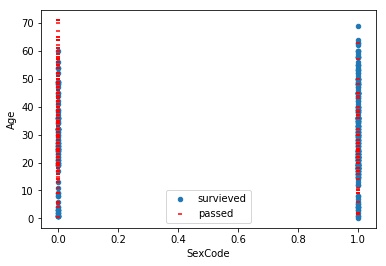

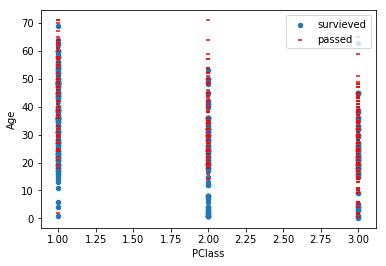

In [3]:
ax = data[y>0].plot(kind='scatter', x="SexCode",y="Age", label='survieved')
data[y<=0].plot(kind='scatter', x="SexCode",y="Age", color='red', marker='_', label='passed', ax=ax)

ax = data[y>0].plot(kind='scatter', x="PClass",y="Age", label='survieved')
data[y<=0].plot(kind='scatter', x="PClass",y="Age", color='red', marker='_', label='passed', ax=ax)


__*Recall*__ Given:
-  $X\in \mathbb{R}^{n\times p}$ a dataset with $n$ examples and $p$ features,
-  $y\in \mathbb{R}^n$ the output we want to predict/fit.

We want to learn a function 
$f:\mathbb{R}^{n\times p}\rightarrow \mathbb{R}^n$ s.t. 
$||f\left( X\right) - y||_2$ is minimized.

We will use linear predictor for this task, i.e. we'll try to solve:
$ \min_{\theta} ||X \theta -y||_2 $

And use the optimized $\theta^*$ to define our predictor $f(x) = sign(\theta^Tx)$


Finding the optimal solution is given by the following closed form:
$\theta^{*}=\left(X^{T}X\right)^{-1}X^{T}y$

In [4]:
w = np.linalg.inv(X.T * X) * X.T *y
w

matrix([[-0.23918534],
        [-0.00362094],
        [ 1.09258828]])

Using $\theta^{*}$ we can predict $ \hat{y} = f(x) = sign(x^T\theta^{*})$

Lets check the minimized solution and predictor accuracy:

In [5]:
yhat = X*w
print ("loss: ", np.linalg.norm(y - yhat))
print ("accuracy :", np.sum(np.multiply(yhat, y) > 0) / y.size)

loss:  21.5973492548
accuracy : 0.779100529101


Notice the objective is not zero, which means we cannot find a linear predictor in $X$ which fit $y$ perfectly.

Lets check what our function learned:

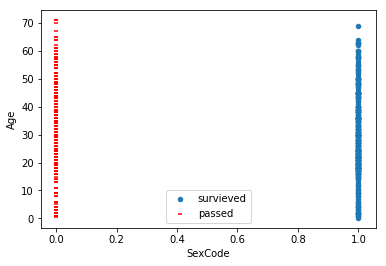

In [6]:
ax = data[yhat>0].plot(kind='scatter', x="SexCode",y="Age", label='survieved')
data[yhat<=0].plot(kind='scatter', x="SexCode",y="Age", color='red', marker='_', label='passed', ax=ax)


Notice that we achieved the optimal solution,
but it is optimal w.r.t $\ell_2$ norm, 
does it make sense to try linear fitting on a classification task?

## Lets try different approach:
- Our model is still linear, i.e. $f(x)=sign(θ^Tx)$, thus all we need is to learn $\theta$.
- This time We'll use convex optimization to define a problem which (hoefully) will:
    - Find better $\theta$. 
    - Have better time complexity.

We can solve the problem exactly by formulating:

\begin{align*}
\min_{w}.\quad & 0\\ 
s.t.\quad & -y^{i}\left\langle x^{i},w\right\rangle \leq0,\forall i\in\left[n\right]
\end{align*}

But since the LS didn't manage to separate the data, the data
is not lineary seperable.
We can coclude that the domain of above oprtimization is empty, i.e. 
$ \bigcap_{i\in [n]} \left\{ w : -y^{i}\left\langle x^{i},w\right\rangle \leq0 \right\} = \emptyset$ 
and thus the above optimization will never return any solution (and objective $\infty$).

So we need to drop constraints, lets try again:
\begin{align*}
\min_{w}.\quad & \sum_{i}\boldsymbol{1}_{y^{i}\left\langle x^{i},w\right\rangle \geq0}
\end{align*}

*BUT* the above formulation is not a convex problem.
we'll solve this issue by minimizing a function which is an upper bound of the previous unconvex problem, but this one will be a convex optimization problem:

\begin{align*}
\min_{w}.\quad & \sum_{i}\max\left\{ 0,1-y^{i}\left\langle x^{i},w\right\rangle \right\}
\end{align*}

Now we can start optimizing, and since we have no constraints we can just use gradient descent.

Denote: $ f(w) = \sum_{i}\max\left\{ 0,1-y^{i}\left\langle x^{i},w\right\rangle \right\}$
and notice that there are many points which are not differential, but practicly it doenst affect us, note that wherever $f(w)$ is defferential we have:
\begin{align*}
\nabla f(w) = \sum_{\left\{ i : y^{i}\left\langle x^{i},w\right\rangle \leq 1 \right\}}-y^{i} x^{i}
\end{align*}

In [7]:
def f(w):
    return np.sum(np.maximum(1- np.multiply(y, X*w).T, np.zeros(y.size)))

def gradient(w):
    g_i = np.array(np.multiply(y, X*w) <= 1).flatten()
    return - (X[g_i].T * y[g_i])


Randomize feasible starting point $w_0$, and  define $ \epsilon $ for the stopping criterion.

In [8]:
w = np.random.normal(0,10,3).reshape(3,1)
eps = 1e-1

Before we use GD. we'll implement the backtracking algorithm:

Given: 
- $w\in dom(f)$
- $\Delta w$ a direction which we are restricted to.

This algorithm returns $t\in \mathbb{R}$ s.t. $ f(w+ t \Delta w )$ is lower than the linear approximation at $w$.

In [9]:
def backtrack(w, g):
    t=1
    g_norm = g.T*g
    base_eval = f(w)
    while f(w + (t*g)) > (base_eval - (0.1*t*g_norm)):
        t /= 2
    return t

Now we can finally use GD to solve the problem.

In [10]:
g = -gradient(w)
t = backtrack(w, g)
i=0
while t * g.T*g > eps :
    g = -gradient(w)
    t = backtrack(w, g)
    w += t * g
    
    if i % 50 == 0:
        print("step number: {}, loss: {}, accuracy: {}".format(
            i, f(w), np.sum(np.multiply(X*w, y) > 0) / y.size))
              
    i+=1
    
print("step number: {}, loss: {}, accuracy: {}".format(
    i, f(w), np.sum(np.multiply(X*w, y) > 0) / y.size))

step number: 0, loss: 33048.60806820634, accuracy: 0.5833333333333334
step number: 50, loss: 905.8831776781146, accuracy: 0.7698412698412699
step number: 96, loss: 643.491118605937, accuracy: 0.7791005291005291


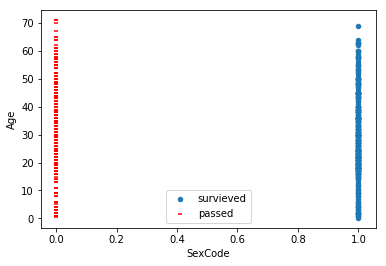

In [11]:
yhat = X*w
ax = data[yhat>0].plot(kind='scatter', x="SexCode",y="Age", label='survieved')
data[yhat<=0].plot(kind='scatter', x="SexCode",y="Age", color='red', marker='_', label='passed', ax=ax)


Notice that we converged to the same accuracy, not the same $w$.

The reason we didn't get better result is probably because the best solution is so trivial (just on sex axis), using other features we might have seen other results. 

The advantage we got in this specific problem is the running time.

Finally note that by taking step size $t=1$ and updating the gradient one example at a time, we get exactly the __perceptron__ algorithm (left to prove that these two changes still produce decreasing steps).